# NMS (Non-Maximum Suppression) o Supresión No Máxima es una técnica crucial en la detección de objetos que se utiliza para refinar los resultados y mejorar la precisión. Su función principal es filtrar los cuadros delimitadores superpuestos que predicen el mismo objeto

El proceso de NMS generalmente implica los siguientes pasos:

Evalúa la Intersección sobre Unión (IoU) entre cuadros delimitadores.

Considera las puntuaciones de confianza asociadas a cada detección.

Elimina las detecciones redundantes, manteniendo solo el cuadro delimitador con la puntuación más alta para cada objeto.

Esta técnica es fundamental en modelos de detección de objetos como YOLO (You Only Look Once), donde ayuda a:

Reducir falsos positivos

Mejorar la interpretabilidad de los resultados

Garantizar que cada objeto se detecte solo una vez

# Comando para entrenar (fine-tuning) el modelo YOLOv5 en un conjunto de datos personalizado. Aquí están los parámetros:

--data data.yaml: Especifica el archivo de configuración del conjunto de datos.

--img 640: Establece el tamaño de la imagen de entrada a 640x640 píxeles.

--batch 16: Define el tamaño del lote (batch size) para el entrenamiento.

--weights keremberke/yolov5m-license-plate: Utiliza los pesos pre-entrenados de un modelo específico para placas de matrícula.

--epochs 10: Establece el número de épocas de entrenamiento a 10.

In [ ]:
#Para ajustar el modelo en un conjunto de datos personalizado:
#yolov5 train --data data.yaml --img 640 --batch 16 --weights keremberke/yolov5m-license-plate --epochs 10


In [ ]:
pip install -U yolov5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.5/953.5 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.0 MB/s eta 0:00:00
   ━━━

In [ ]:
import yolov5
model = yolov5.load('keremberke/yolov5m-license-plate')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


config.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

best.pt:   0%|          | 0.00/42.1M [00:00<?, ?B/s]

# Vamos a agregar un paso de post-procesamiento para realizar OCR (Reconocimiento Óptico de Caracteres) en las placas de matrícula detectadas. Para esto, utilizaremos la biblioteca Tesseract OCR a través de su wrapper en Python, pytesseract.

In [ ]:
 !apt-get install -y tesseract-ocr
 !pip install pytesseract

# IMPLEMENTACION SOLICITANDO IMAGE_PATH

In [ ]:
import cv2
import torch
import pytesseract
import numpy as np
from google.colab.patches import cv2_imshow
from IPython.display import display, Image

def detect_and_read_license_plates(image_path):
    # Verificar si el archivo existe
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"La imagen no se encuentra en la ruta especificada: {image_path}")

    # Leer la imagen
    img = cv2.imread(image_path)

    # Verificar si la imagen se cargó correctamente
    if img is None:
        raise ValueError(f"No se pudo cargar la imagen: {image_path}. Asegúrate de que el formato de archivo es compatible.")

    # Convertir a RGB si es en escala de grises
    if len(img.shape) == 2 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Configuración de los parámetros del modelo de detección de objetos
    model = yolov5.load('keremberke/yolov5m-license-plate')
    model.conf = 0.25
    model.iou = 0.45
    model.agnostic = False
    model.multi_label = False
    model.max_det = 1000

    # Procesamiento de la imagen
    with torch.amp.autocast("cuda", enabled=True):
        results = model(img, size=640)

    # Extracción de predicciones
    predictions = results.pred[0]
    boxes = predictions[:, :4]
    scores = predictions[:, 4]
    categories = predictions[:, 5]

    # Dibujar las detecciones en la imagen
    img_with_boxes = results.render()[0]

    # Convertir img_with_boxes a un array de NumPy modificable
    img_with_boxes = np.array(img_with_boxes).copy()

    # Mostrar la imagen con las detecciones
    #cv2_imshow(img_with_boxes)

    # Post-procesamiento: OCR en las placas detectadas
    license_plate_texts = []
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        plate_img = img[y1:y2, x1:x2]

        # Preprocesamiento de la imagen de la placa
        plate_img_gray = cv2.cvtColor(plate_img, cv2.COLOR_RGB2GRAY)
        plate_img_gray = cv2.threshold(plate_img_gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

        # Realizar OCR
        text = pytesseract.image_to_string(plate_img_gray, config='--psm 7 --oem 3')

        # Limpiar el texto (eliminar espacios y saltos de línea)
        text = text.strip().replace('\n', '').replace(' ', '')

        license_plate_texts.append(text)

        # Dibujar el texto en la imagen
        cv2.putText(img_with_boxes, text, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

    # Mostrar la imagen final con las placas leídas
    cv2_imshow(img_with_boxes)

    return boxes, scores, categories, license_plate_texts

# Uso de la función

/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


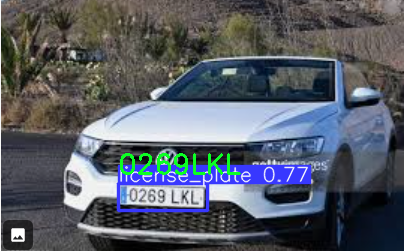

Placa 1: 0269LKL


In [ ]:
try:
    boxes, scores, categories, texts = detect_and_read_license_plates('8.png')

    # Imprimir los textos de las placas detectadas
    for i, text in enumerate(texts):
        print(f"Placa {i+1}: {text}")
except FileNotFoundError as e:
    print(f"Error: {e}")
except ValueError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


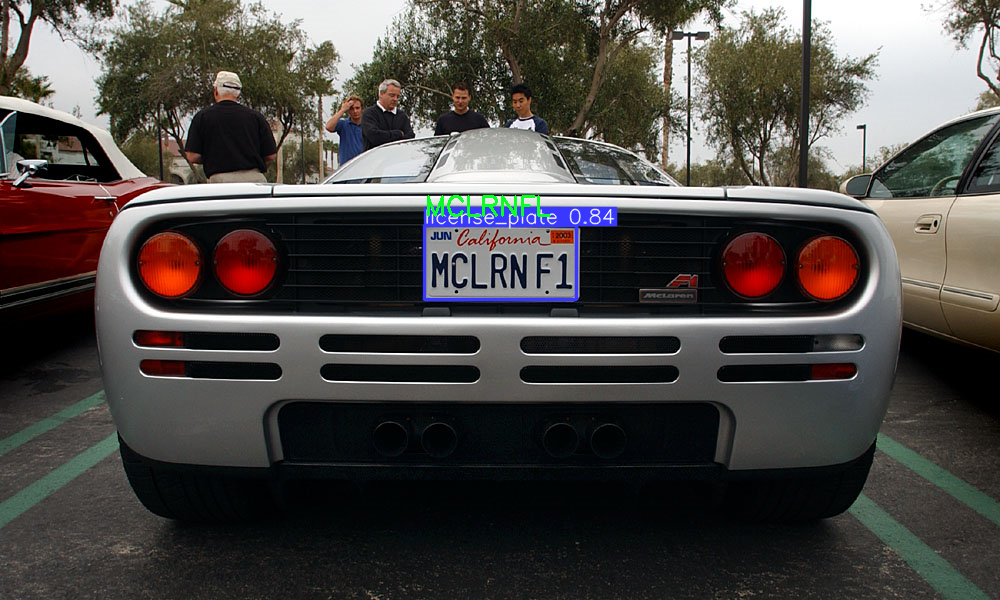

Placa 1: MCLRNFL


In [ ]:
try:
    boxes, scores, categories, texts = detect_and_read_license_plates('car.png')

    # Imprimir los textos de las placas detectadas
    for i, text in enumerate(texts):
        print(f"Placa {i+1}: {text}")
except FileNotFoundError as e:
    print(f"Error: {e}")
except ValueError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


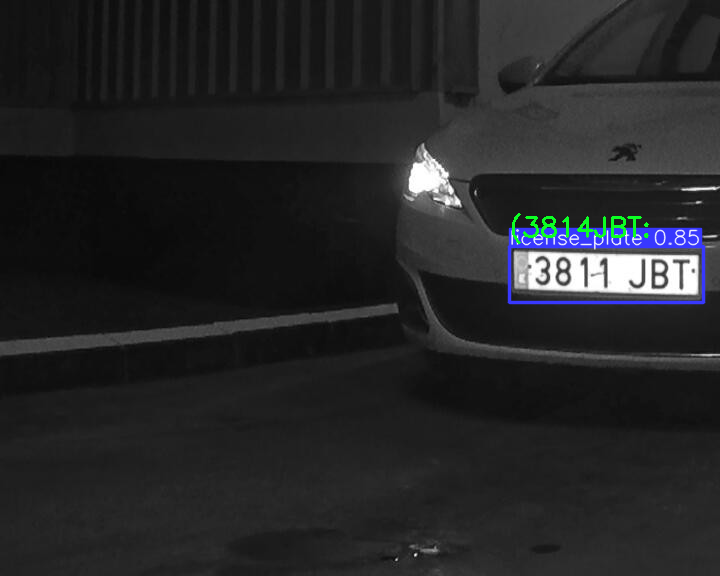

Placa 1: (3814JBT:


In [ ]:
try:
    boxes, scores, categories, texts = detect_and_read_license_plates('9.jpg')

    # Imprimir los textos de las placas detectadas
    for i, text in enumerate(texts):
        print(f"Placa {i+1}: {text}")
except FileNotFoundError as e:
    print(f"Error: {e}")
except ValueError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


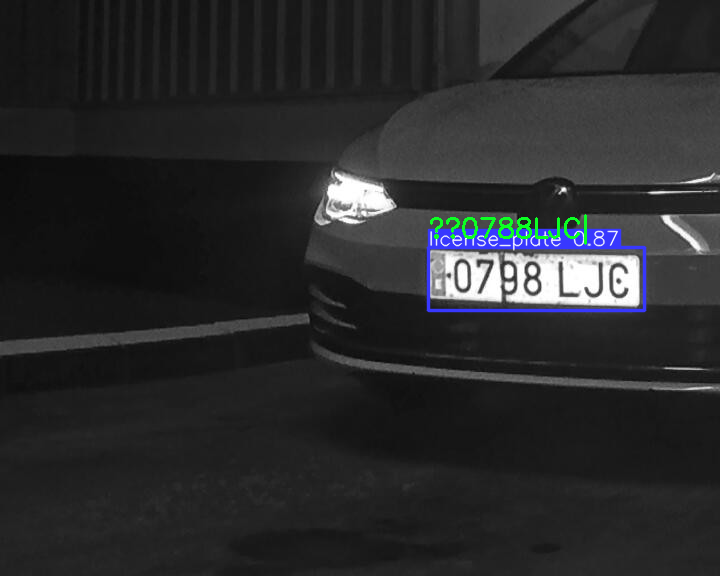

Placa 1: £0788LJC|


In [ ]:
try:
    boxes, scores, categories, texts = detect_and_read_license_plates('10.jpg')

    # Imprimir los textos de las placas detectadas
    for i, text in enumerate(texts):
        print(f"Placa {i+1}: {text}")
except FileNotFoundError as e:
    print(f"Error: {e}")
except ValueError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


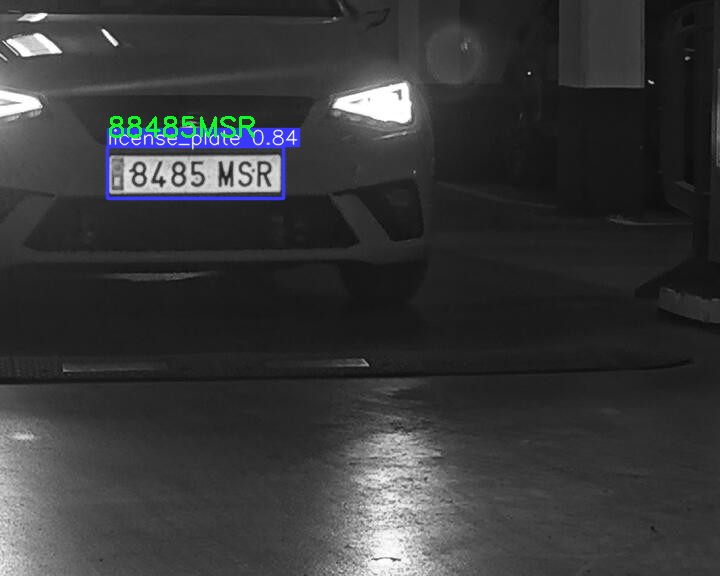

Placa 1: 88485MSR


In [ ]:
try:
    boxes, scores, categories, texts = detect_and_read_license_plates('6.jpg')

    # Imprimir los textos de las placas detectadas
    for i, text in enumerate(texts):
        print(f"Placa {i+1}: {text}")
except FileNotFoundError as e:
    print(f"Error: {e}")
except ValueError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


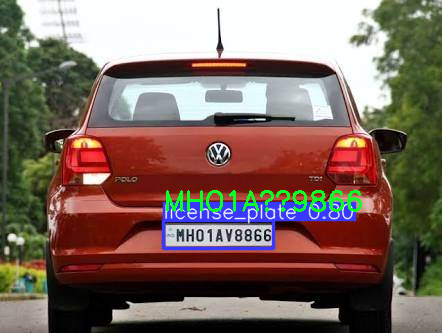

Placa 1: MHO1A¥9866


In [ ]:
try:
    boxes, scores, categories, texts = detect_and_read_license_plates('car6.jpg')

    # Imprimir los textos de las placas detectadas
    for i, text in enumerate(texts):
        print(f"Placa {i+1}: {text}")
except FileNotFoundError as e:
    print(f"Error: {e}")
except ValueError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

#IMPLEMENTACION SOLICITANDO IMAGEN

In [ ]:
import cv2
import torch
import pytesseract
import numpy as np
from google.colab.patches import cv2_imshow
from IPython.display import display, Image
from google.colab import files

def detect_and_read_license_plates():
    # Solicitar al usuario que cargue una imagen
    uploaded = files.upload()

    if not uploaded:
        raise ValueError("No se cargó ninguna imagen.")

    # Obtener el nombre del archivo cargado
    image_name = list(uploaded.keys())[0]

    # Leer la imagen
    img = cv2.imdecode(np.frombuffer(uploaded[image_name], np.uint8), cv2.IMREAD_COLOR)

    # Verificar si la imagen se cargó correctamente
    if img is None:
        raise ValueError(f"No se pudo cargar la imagen: {image_name}. Asegúrate de que el formato de archivo es compatible.")

    # Convertir a RGB si es en escala de grises
    if len(img.shape) == 2 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Configuración de los parámetros del modelo de detección de objetos
    model = yolov5.load('keremberke/yolov5m-license-plate')
    model.conf = 0.25
    model.iou = 0.45
    model.agnostic = False
    model.multi_label = False
    model.max_det = 1000

    # Procesamiento de la imagen
    with torch.amp.autocast("cuda", enabled=True):
        results = model(img, size=640)

    # Extracción de predicciones
    predictions = results.pred[0]
    boxes = predictions[:, :4]
    scores = predictions[:, 4]
    categories = predictions[:, 5]

    # Dibujar las detecciones en la imagen
    img_with_boxes = results.render()[0]

    # Convertir img_with_boxes a un array de NumPy modificable
    img_with_boxes = np.array(img_with_boxes).copy()

    # Post-procesamiento: OCR en las placas detectadas
    license_plate_texts = []
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        plate_img = img[y1:y2, x1:x2]

        # Preprocesamiento de la imagen de la placa
        plate_img_gray = cv2.cvtColor(plate_img, cv2.COLOR_RGB2GRAY)
        plate_img_gray = cv2.threshold(plate_img_gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

        # Realizar OCR
        text = pytesseract.image_to_string(plate_img_gray, config='--psm 7 --oem 3')

        # Limpiar el texto (eliminar espacios y saltos de línea)
        text = text.strip().replace('\n', '').replace(' ', '')

        license_plate_texts.append(text)

        # Dibujar el texto en la imagen
        cv2.putText(img_with_boxes, text, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

    # Mostrar la imagen final con las placas leídas
    cv2_imshow(img_with_boxes)

    return boxes, scores, categories, license_plate_texts

# Uso de la función

Saving E1,CAM1,250210005134979,8485MSR,9992.jpg to E1,CAM1,250210005134979,8485MSR,9992 (1).jpg


/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


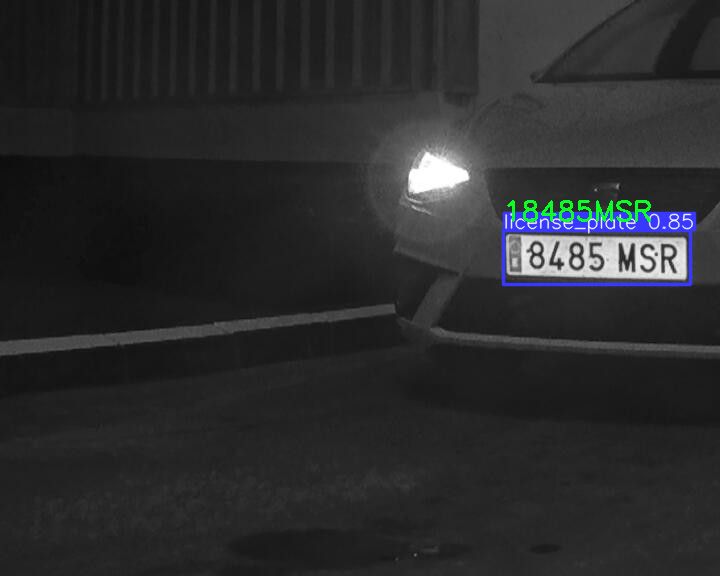

Placa 1: 18485MSR


In [ ]:
try:
    boxes, scores, categories, texts = detect_and_read_license_plates()

    # Imprimir los textos de las placas detectadas
    for i, text in enumerate(texts):
        print(f"Placa {i+1}: {text}")
except FileNotFoundError as e:
    print(f"Error: {e}")
except ValueError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")